In [1]:
!pip install numpy pandas matplotlib 
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

2024-08-05 19:31:36.269113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 19:31:36.284135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 19:31:36.288536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 19:31:36.304870: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 19:31:37.253773: W tensorflow/compiler/tf2

In [2]:
!nvidia-smi

Mon Aug  5 19:31:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 41%   67C    P2            248W /  300W |   35476MiB /  49140MiB |     88%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

|   6  NVIDIA RTX A6000               Off |   00000000:C1:00.0 Off |                  Off |
| 52%   76C    P2            281W /  300W |   41390MiB /  49140MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
|   7  NVIDIA RTX A6000               Off |   00000000:E1:00.0 Off |                  Off |
| 50%   67C    P2             95W /  300W |   47166MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                      

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import tensorflow as tf

# List all GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Check if GPUs are visible to TensorFlow
if len(gpus) == 0:
    print("No GPUs detected by TensorFlow.")
else:
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu.name}")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: /physical_device:GPU:0


In [6]:
# Set the visible GPU device to GPU 2
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU 2 as visible device
        tf.config.set_visible_devices(gpus[0], 'GPU')
        
        # Optionally, set memory growth to prevent TensorFlow from allocating all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Print the name of the GPU being used
        print(f"Using GPU: {gpus[0].name}")

    except RuntimeError as e:
        print(f"Error: {e}")

# Example TensorFlow operation to check if GPU is being used
def check_gpu():
    with tf.device('/device:GPU:0'):
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        c = tf.add(a, b)
        print(c)

check_gpu()

Using GPU: /physical_device:GPU:0
tf.Tensor(
[[ 2.  4.  6.]
 [ 8. 10. 12.]], shape=(2, 3), dtype=float32)


2024-08-05 19:32:02.377795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46593 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [8]:
def create_dataset(num_train_samples=1000, num_test_samples=250):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

    # Limit the number of samples
    train_images = train_images[:num_train_samples]
    train_labels = train_labels[:num_train_samples]
    test_images = test_images[:num_test_samples]
    test_labels = test_labels[:num_test_samples]

    # Normalizing and resizing MNIST digits to be placed in a 256x256 image
    def place_digit(image):
        size = 256
        placement = np.zeros((size, size), dtype=np.float32)
        x_offset = np.random.randint(0, size - 28)
        y_offset = np.random.randint(0, size - 28)
        placement[y_offset:y_offset + 28, x_offset:x_offset + 28] = image
        return placement, [x_offset / size, y_offset / size, (x_offset + 28) / size, (y_offset + 28) / size]

    # Applying the function and separating results
    train_results = [place_digit(img) for img in train_images]
    test_results = [place_digit(img) for img in test_images]

    # Normalize and reshape images
    train_images = np.array([res[0] for res in train_results]) / 255.0
    train_bboxes = np.array([res[1] for res in train_results])
    test_images = np.array([res[0] for res in test_results]) / 255.0
    test_bboxes = np.array([res[1] for res in test_results])

    # Expand dimensions to include channel information
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    return (train_images, train_bboxes, train_labels), (test_images, test_bboxes, test_labels)

(train_images, train_bboxes, train_labels), (test_images, test_bboxes, test_labels) = create_dataset()

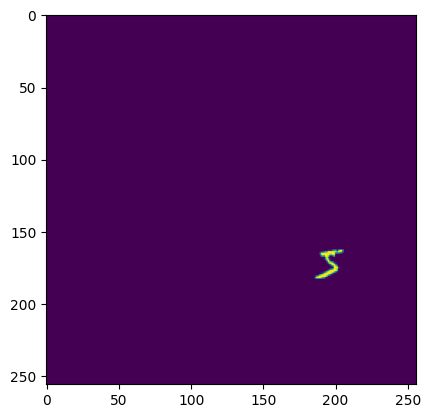

In [9]:
plt.imshow(train_images[0])

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

def crop_and_resize_image(image, box, target_size=(28, 28)):
    """
    Crops an image to the specified bounding box and then resizes it to the target size.
    
    :param image: A 3-D Tensor of shape [height, width, channels].
    :param box: A 1-D Tensor of shape [4] containing the bounding box (y_offset, x_offset, target_height, target_width).
    :param target_size: A tuple specifying the target height and width.
    :return: A resized 3-D Tensor.
    """
    box = tf.cast(box, tf.int32)  # Ensure the box coordinates are integers
    cropped_image = tf.image.crop_to_bounding_box(image, box[1], box[0], target_size[0], target_size[1])
    resized_image = tf.image.resize(cropped_image, target_size)
    return resized_image

def crop_and_resize_batch(images, boxes, target_size=(28, 28)):
    """
    Applies cropping and resizing to each image in a batch with corresponding bounding boxes.
    
    :param images: A 4-D Tensor of shape [batch_size, height, width, channels].
    :param boxes: A 2-D Tensor of shape [batch_size, 4] containing bounding boxes.
    :param target_size: A tuple specifying the target height and width.
    :return: A 4-D Tensor of cropped and resized images.
    """
    def process_image_and_box(image, box):
        return crop_and_resize_image(image, box, target_size)
    
    return tf.vectorized_map(lambda x: process_image_and_box(x[0], x[1]), (images, boxes))

# Example custom layer for cropping and resizing
class CroppingAndResizingLayer(tf.keras.layers.Layer):
    def __init__(self, target_size=(28, 28), **kwargs):
        super(CroppingAndResizingLayer, self).__init__(**kwargs)
        self.target_size = target_size
        self.image_size = (256, 256)

    def call(self, inputs):
        images, boxes = inputs
        boxes = tf.cast(boxes * self.image_size[0], tf.int32)  # Ensure boxes are integers
        return crop_and_resize_batch(images, boxes, self.target_size)

# Usage Example
# Assuming 'model_input' and 'bbox_coords' are your input images and bounding box coordinates
# crop_layer = CropLayer(target_size=(28, 28))
# cropped_and_padded_images = crop_layer([model_input, bbox_coords])

def create_model():
    input_layer = Input(shape=(256, 256, 1))
    
    # Base convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    # Localization branch predicts coordinates for cropping
    localization = Dense(128, activation='relu')(x)
    coords = Dense(4, activation='sigmoid', name='localization_output')(localization)  # Named output for localization
    
    # Cropping layer
    crop_layer = CroppingAndResizingLayer(target_size=(28, 28))([input_layer, coords])
    
    # Classification branch
    classification_input = Flatten()(crop_layer)
    classification = Dense(128, activation='relu')(classification_input)
    classification = Dropout(0.5)(classification)
    classification_output = Dense(10, activation='softmax', name='classification_output')(classification)  # Named output for classification
    
    # Construct the full model
    model = Model(inputs=input_layer, outputs=[coords, classification_output])
    
    return model

model = create_model()

In [11]:
from tensorflow.keras import backend as K
import tensorflow as tf

def clear_session():
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    # Clear the GPU memory
    from tensorflow.python.framework import ops
    ops.reset_default_graph()

clear_session()

In [12]:
model.compile(
    optimizer='adam',
    loss={
        'localization_output': 'mean_squared_error',  # Corrected to the actual output layer name
        'classification_output': 'sparse_categorical_crossentropy'  # Corrected to the actual output layer name
    },
    loss_weights={
        'localization_output': 1.0,  # Ensure the weight matches the importance of the task
        'classification_output': 1.0  # Ensure the weight matches the importance of the task
    },
    metrics={
        'localization_output': ['mae'],  # Metrics for the localization output
        'classification_output': ['accuracy']  # Metrics for the classification output
    }
)

In [13]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_images, 
        {
            'localization_output': train_bboxes, 
            'classification_output': train_labels
        },
        validation_data=(
            test_images, 
            {
                'localization_output': test_bboxes, 
                'classification_output': test_labels
            }
        ),
        epochs=10,
        batch_size=16
    )


Epoch 1/10


I0000 00:00:1722886348.227751 1174163 service.cc:146] XLA service 0x7f5540007cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722886348.227867 1174163 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-05 19:32:28.379918: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1722886348.544275 1174163 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert/Assert
W0000 00:00:1722886348.544723 1174163 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_1/Assert
W0000 00:00:1722886348.544994 1174163 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulParti

 1/63 ━━━━━━━━━━━━━━━━━━━━ 11:27 11s/step - classification_output_accuracy: 0.0625 - localization_output_mae: 0.2232 - loss: 2.3688

I0000 00:00:1722886357.385325 1174163 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722886357.800412 1174170 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert/Assert
W0000 00:00:1722886357.800460 1174170 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_1/Assert
W0000 00:00:1722886357.800509 1174170 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_2/Assert
W0000 00:00:1722886357.800521 1174170 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_3/Assert
W0000 00:00:1722886357.800814 1174170 assert_op.cc:38] Ignoring Assert

 2/63 ━━━━━━━━━━━━━━━━━━━━ 7:24 7s/step - classification_output_accuracy: 0.0625 - localization_output_mae: 0.2225 - loss: 2.3695  

W0000 00:00:1722886365.032557 1174157 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert/Assert
W0000 00:00:1722886365.032613 1174157 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_1/Assert
W0000 00:00:1722886365.032651 1174157 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_2/Assert
W0000 00:00:1722886365.032666 1174157 assert_op.cc:38] Ignoring Assert operator functional_1/cropping_and_resizing_layer_1/StatefulPartitionedCall/loop_body/crop_to_bounding_box/Assert_3/Assert


23/63 ━━━━━━━━━━━━━━━━━━━━ 3:58 6s/step - classification_output_accuracy: 0.0614 - localization_output_mae: 0.1574 - loss: 2.3496

2024-08-05 19:34:53.250920: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %convolution.302 = f32[16,256,256,32]{3,2,1,0} convolution(f32[16,256,256,1]{3,2,1,0} %constant.301, f32[3,3,1,32]{3,2,1,0} %constant.300), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01io->b01f, metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/mattwilk/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1177}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-08-05 19:34:53.303803: E external/local_xla/xla/service/slow_opera

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - classification_output_accuracy: 0.0762 - localization_output_mae: 0.1180 - loss: 2.3533WARNING:tensorflow:Using a while_loop for converting ResizeBilinear cause there is no registered converter for this op.
63/63 ━━━━━━━━━━━━━━━━━━━━ 484s 8s/step - classification_output_accuracy: 0.0765 - localization_output_mae: 0.1173 - loss: 2.3535 - val_classification_output_accuracy: 0.1760 - val_localization_output_mae: 0.0319 - val_loss: 2.3426
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 476s 8s/step - classification_output_accuracy: 0.1002 - localization_output_mae: 0.0248 - loss: 2.3930 - val_classification_output_accuracy: 0.2040 - val_localization_output_mae: 0.0183 - val_loss: 2.2487
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 498s 8s/step - classification_output_accuracy: 0.2325 - localization_output_mae: 0.0147 - loss: 2.2036 - val_classification_output_accuracy: 0.2480 - val_localization_output_mae: 0.0157 - val_loss: 2.1670
Epoch 4/10
 9/63 ━━━━━━━━━━━━━━━━━━

2024-08-05 19:57:44.305762: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 128.00MiB (134217728 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-08-05 19:57:44.305912: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INTERNAL: Failed to allocate 134217728 bytes for new constant
	 [[{{node StatefulPartitionedCall}}]]


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/mattwilk/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/mattwilk/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1173525/1636613771.py", line 2, in <module>

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to allocate 134217728 bytes for new constant
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_4070]

In [97]:
print(test_images.shape)
y_pred = model.predict(test_images)


(250, 256, 256, 1)


2024-08-02 19:48:07.516445: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1578] failed to allocate 64.00MiB (67108864 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/mattwilk/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/mattwilk/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/mattwilk/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/mattwilk/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2262476/2676898038.py", line 2, in <module>

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 508, in predict

  File "/home/mattwilk/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

Failed to allocate 67108864 bytes for new constant
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_452199]

[0.015625  0.2421875 0.125     0.3515625]
[0.02744406 0.26661    0.12616605 0.38507006]
7
[0.08879827 0.10580781 0.07657495 0.1211955  0.14983183 0.11164243
 0.07547764 0.12235857 0.09281766 0.05549541]


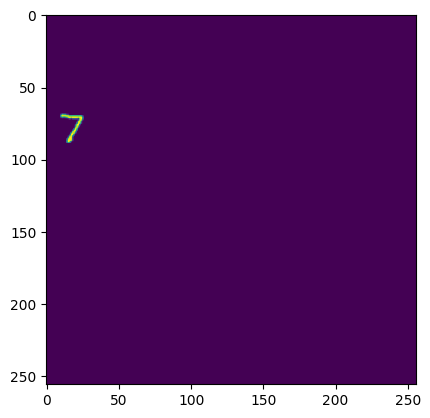

In [54]:
plt.imshow(test_images[0])
print(test_bboxes[0])
print(y_pred[0][0])
print(test_labels[0])
print(y_pred[1][0])

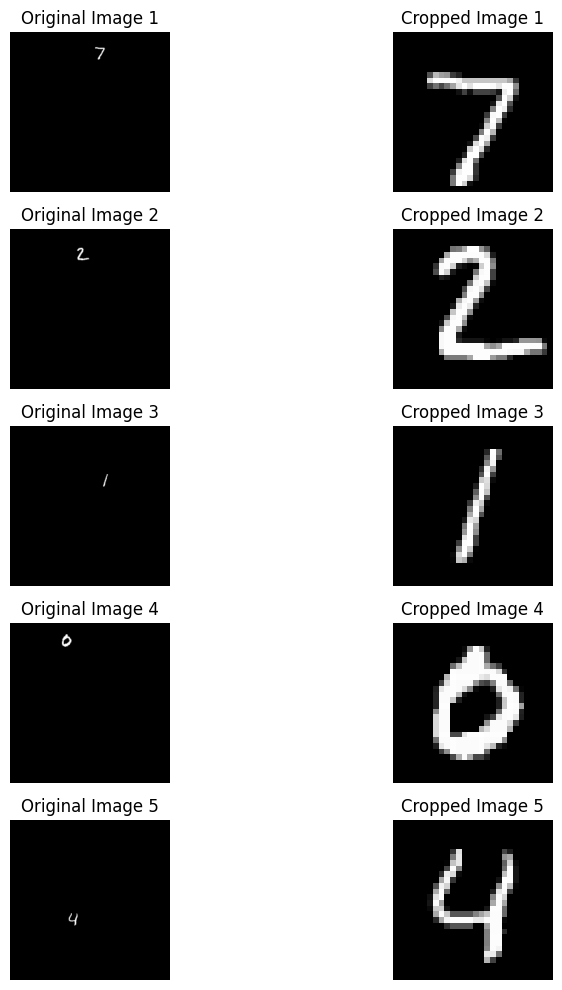

In [11]:
def test_crop_layer():
    # Create dummy data
    batch_size = 1
    img_height, img_width = 256, 256
    channels = 1
    target_size = (28, 28)
    
    dummy_images = test_images
    dummy_coords = test_bboxes
    
    crop_layer = CroppingAndResizingLayer(target_size=target_size)
    
    cropped_images = crop_layer([dummy_images, dummy_coords])
    
    # Plot the original and cropped images for the first 5 examples
    plt.figure(figsize=(10, 10))
    for i in range(5):
        original_image = test_images[i]
        cropped_image = cropped_images[i, :, :, 0].numpy()
        
        plt.subplot(5, 2, 2 * i + 1)
        plt.title(f"Original Image {i+1}")
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')
        
        plt.subplot(5, 2, 2 * i + 2)
        plt.title(f"Cropped Image {i+1}")
        plt.imshow(cropped_image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the test function
test_crop_layer()

#4-32 62-90